<a href="https://colab.research.google.com/github/KoJl9lH-59rus/ML_FINAL/blob/main/%D0%98%D1%82%D0%BE%D0%B3%D0%BE%D0%B2%D0%B0%D1%8F%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0%20%D0%BF%D0%BE%20%D0%A2%D0%B5%D1%85%D0%BD%D0%BE%D0%BB%D0%BE%D0%B3%D0%B8%D1%8F%D0%BC%20%D0%9C%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE%20%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline

#оценка точности моделей
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

#рассматриваемые модели классификации
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

#Вспомогательные для классификации
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

# Задача

Используя набор данных о разрывах в электрической сети, написать код, на основе которого модель будет классифицировать состояние электросети.

Набор данных содержит информацию о линиях разрыва, о линейном токе и линейном напряжении фаз:
* G - Часть линии разрыва (Земля) если 1, иначе 0
* C - Часть линии разрыва (Фаза C) если 1, иначе 0
* B - Часть линии разрыва (Фаза B) если 1, иначе 0
* A - Часть линии разрыва (Фаза A) если 1, иначе 0
* Ia - Линейный ток фазы А
* Ib - Линейный ток фазы B
* Ic - Линейный ток фазы C
* Va - Линейное напряжение фазы А
* Vb - Линейное напряжение фазы B
* Vc - Линейное напряжение фазы C

Классификация разрывов составляется из стобцов G, C, B, A. Всего классов 6, примеры:

[0 0 0 0] - Нет проблем

[1 0 0 1] - LG (разрыв между фазой A и G (землёй))

[0 0 1 1] - LL (разрыв между фазой A и фазой B)

[1 0 1 1] - LLG (разрыв между фазами A,B и G (землёй))

[0 1 1 1] - LLL (разрыв между фазами всеми тремя вазами)

[1 1 1 1] - LLLG (разрыв между фазами всеми тремя вазами и G (землёй))

# Загрузка датасета и вывод информации о нем

In [2]:
#Загружаем датасет из github

url = 'https://raw.githubusercontent.com/KoJl9lH-59rus/ML_FINAL/refs/heads/main/classData.csv'

dataset = pd.read_csv(url)

In [3]:
dataset.shape

(7861, 10)

В датасете 10 столбцов и 7861 строка


In [4]:
dataset.head()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983


In [5]:
print(dataset.info(), '\n')
print('Количество пропусков = ', dataset.isnull().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7861 entries, 0 to 7860
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   G       7861 non-null   int64  
 1   C       7861 non-null   int64  
 2   B       7861 non-null   int64  
 3   A       7861 non-null   int64  
 4   Ia      7861 non-null   float64
 5   Ib      7861 non-null   float64
 6   Ic      7861 non-null   float64
 7   Va      7861 non-null   float64
 8   Vb      7861 non-null   float64
 9   Vc      7861 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 614.3 KB
None 

Количество пропусков =  0


Нулевые значения отсутсвуют, нормализовать никакие данные не нужно.

## Вывод статистических данных

In [6]:
dataset.describe()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
count,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000
mean,0.432006,0.411271,0.555527,0.571429,13.721194,-44.845268,34.392394,-0.007667,0.001152,0.006515
std,0.495387,0.492095,0.496939,0.494903,464.741671,439.269195,371.107412,0.289150,0.313437,0.307897
min,0.000000,0.000000,0.000000,0.000000,-883.542316,-900.526951,-883.357762,-0.620748,-0.608016,-0.612709
25%,0.000000,0.000000,0.000000,0.000000,-119.802518,-271.845947,-61.034219,-0.130287,-0.159507,-0.215977
50%,0.000000,0.000000,1.000000,1.000000,2.042805,5.513317,-4.326711,-0.005290,0.001620,0.009281
75%,1.000000,1.000000,1.000000,1.000000,227.246377,91.194282,49.115141,0.111627,0.153507,0.239973
max,1.000000,1.000000,1.000000,1.000000,885.738571,889.868884,901.274261,0.595342,0.627875,0.600179


# Обработка датасета

Добавим столбец, в который на основании значений четырех столбцов GCBA будут занесены классы, признак станет целевым. Классы будем рассматривать следующим образом:

0 - Нет неисправности

1 - LL

2 - LLL

3 - LG

4 - LLG  

5 - LLLG

In [7]:
fault_mapping = {
    (0,0,0,0): 0, # Нет неисправности
    (0,0,1,1): 1, # Неисправность LL
    (0,1,0,1): 1, # Неисправность LL
    (0,1,1,0): 1, # Неисправность LL
    (0,1,1,1): 2, # Неисправность LLL
    (1,0,0,1): 3, # Неисправность LG
    (1,0,1,0): 3, # Неисправность LG
    (1,0,1,1): 4, # Неисправность LLG
    (1,1,0,0): 3, # Неисправность LG
    (1,1,0,1): 4, # Неисправность LLG
    (1,1,1,0): 4, # Неисправность LLG
    (1,1,1,1): 5,  # Неисправность LLLG
}

# Применяем замену
dataset['Class'] = dataset[['G', 'C', 'B', 'A']].apply(lambda x: fault_mapping[tuple(x)], axis=1)
dataset.head()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,Class
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,3
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,3
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,3
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,3
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,3


# Визуализируем данные по классам

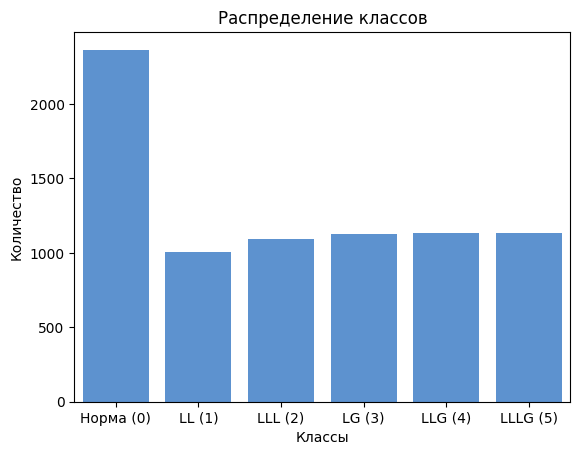

In [8]:
# Создание countplot
sns.countplot(x=dataset['Class'], color='#4A90E2')

# Задаем метки для классов
class_labels = ['Норма (0)', 'LL (1)', 'LLL (2)', 'LG (3)', 'LLG (4)', 'LLLG (5)']
plt.xticks(ticks=range(len(class_labels)), labels=class_labels)

# Показать график
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.title('Распределение классов')
plt.show()

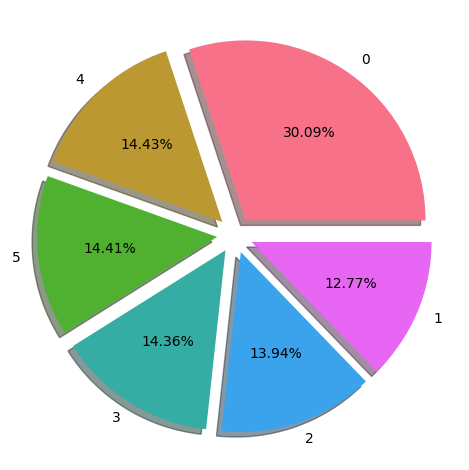

In [9]:
ax =plt.subplot(1,1,1)
ax=dataset['Class'].value_counts().plot.pie(explode=[0.1, 0.1,0.1,0.1, 0.1,0.1],autopct='%1.2f%%',shadow=True);
plt.tight_layout()
plt.axis('off');

Есть дисбаланс в сторону класса 0 (то есть нормальной работы)

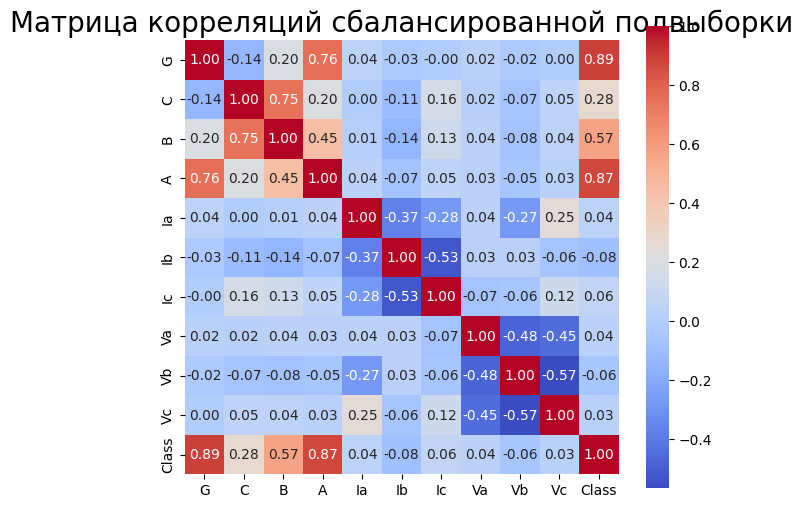

In [10]:
plt.figure(figsize=(7,6))
sns.heatmap(dataset.corr(), annot = True, cmap = 'coolwarm', fmt='.2f', square=True)
plt.title('Матрица корреляций сбалансированной подвыборки', fontsize=20)
plt.show()

# Классификация


## Записываем классификаторы в список

In [11]:
tuned_classifiers = {
    "Logisitic Regression": LogisticRegression(max_iter=10000, random_state=42),
    "KNearest": KNeighborsClassifier(n_neighbors=6),
    "Gaussian Naive Bayes": GaussianNB(),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=100, learning_rate=0.4, max_depth=5, random_state=42),
    "Support Vector Classifier": SVC(kernel='rbf', gamma='auto', C=1.0),
    "Random Forest Classifier": RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42),
}

## Разделяем полученный датасет на тестовую и тренировочную выборки, решаем проблему дисбаланса с помощью RandomUnderSampler и SMOTE


In [12]:
X = dataset.drop(columns=['Class'])
y = dataset['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
# Используем StratifiedKFold для обеспечения стратифицированной кросс-валидации
# Это объект кросс-валидации, который позволяет сохранить процент образцов для каждого класса в каждом фоне.
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)  # 5 образцов для кросс-валидации

# Создаем объект для уменьшения выборки для большинства
sampler = RandomUnderSampler()

## Выбираем лучшую модель для классификации

In [13]:
import time

accuracy_data = []

# Проходим по словарю с классификаторами
for key, classifier in tuned_classifiers.items():
    time1 = time.time()
    # Создаем список шагов для пайплайна машинного обучения
    steps = [ ('u', sampler), ('model', classifier)]  # Шаги: увеличенная выборка, уменьшенная выборка и модель

    # Создаем пайплайн машинного обучения
    FiPipeline = Pipeline(steps=steps)  # Инициализация пайплайна с указанными шагами

    # Кросс-валидация классификаторов с использованием определенного пайплайна
    scores = cross_val_score(FiPipeline, X_train, y_train, cv=skf)  # Оценка модели с помощью кросс-валидации
    time2 = time.time()

    accuracy = round(scores.mean() * 100, 2)
    accuracy_data.append([key, accuracy])

    print(f"Название: {key}, оценка точности: {accuracy} %, время обучения : {(time2-time1):0.2f} секунд")

Название: Logisitic Regression, оценка точности: 100.0 %, время обучения : 41.21 секунд
Название: KNearest, оценка точности: 83.13 %, время обучения : 0.60 секунд
Название: Gaussian Naive Bayes, оценка точности: 100.0 %, время обучения : 0.09 секунд
Название: Decision Tree Classifier, оценка точности: 100.0 %, время обучения : 0.16 секунд
Название: Gradient Boosting Classifier, оценка точности: 100.0 %, время обучения : 8.45 секунд
Название: Support Vector Classifier, оценка точности: 66.48 %, время обучения : 9.84 секунд
Название: Random Forest Classifier, оценка точности: 100.0 %, время обучения : 2.70 секунд


In [14]:
y_train_cat = to_categorical(y_train, num_classes=6)
y_test_cat = to_categorical(y_test, num_classes=6)


# Создание модели
model_n = Sequential()
model_n.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model_n.add(Dense(32, activation='relu'))
model_n.add(Dense(16, activation='relu'))
model_n.add(Dense(6, activation='sigmoid'))

# Компиляция модели, задача многоклассовая классификация
model_n.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучение модели
history = model_n.fit(X_train, y_train_cat,
                    epochs=50,
                    validation_data=(X_test, y_test_cat))

# Оценка модели
test_loss, test_acc = model_n.evaluate(X_test, y_test_cat)
print()
accuracy = round(test_acc, 4)*100
accuracy_data.append(["Нейросеть",accuracy])
print(f'Тестовая точность: {accuracy}')
print()

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3461 - loss: 10.4885 - val_accuracy: 0.5607 - val_loss: 1.3081
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6237 - loss: 1.2734 - val_accuracy: 0.6694 - val_loss: 1.3276
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7021 - loss: 1.1112 - val_accuracy: 0.7330 - val_loss: 1.0594
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7261 - loss: 1.0728 - val_accuracy: 0.7775 - val_loss: 1.0282
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7621 - loss: 0.8834 - val_accuracy: 0.7839 - val_loss: 0.7017
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7609 - loss: 0.9330 - val_accuracy: 0.8042 - val_loss: 0.5913
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7902 - loss: 0.7223 - val_accuracy: 0.7680 - val_loss: 0.6007
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7781 - loss: 0.6421 - val_accuracy: 0.7616 - val

## Визуализируем полученные результаты

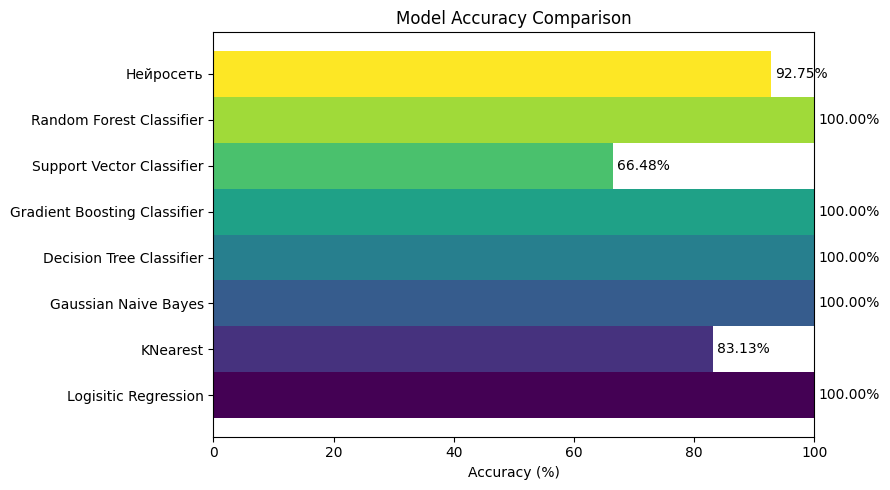

In [15]:
import matplotlib.pyplot as plt

# Получаем название + точность
models = [item[0] for item in accuracy_data]
accuracies = [item[1] for item in accuracy_data]

colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

plt.figure(figsize=(9, 5))
bar_width = 1
bars = plt.barh(models, accuracies, height=bar_width, color=colors)

plt.xlabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.yticks(models)
plt.xlim(0, 100)

def autolabel(bars):
    for bar in bars:
        width = bar.get_width()
        plt.annotate(f'{width:.2f}%',
                     xy=(width, bar.get_y() + bar.get_height() / 2),
                     xytext=(3, 0),
                     textcoords="offset points",
                     ha='left', va='center')

autolabel(bars)

plt.tight_layout()
plt.show()

Пять классификаторов имеют точность 100%, выберем наивный Байесовский.

## Обучение модели

              precision    recall  f1-score   support

   Норма (0)       1.00      1.00      1.00       482
      LL (1)       1.00      1.00      1.00       201
     LLL (2)       1.00      1.00      1.00       199
      LG (3)       1.00      1.00      1.00       242
     LLG (4)       1.00      1.00      1.00       238
    LLLG (5)       1.00      1.00      1.00       211

    accuracy                           1.00      1573
   macro avg       1.00      1.00      1.00      1573
weighted avg       1.00      1.00      1.00      1573



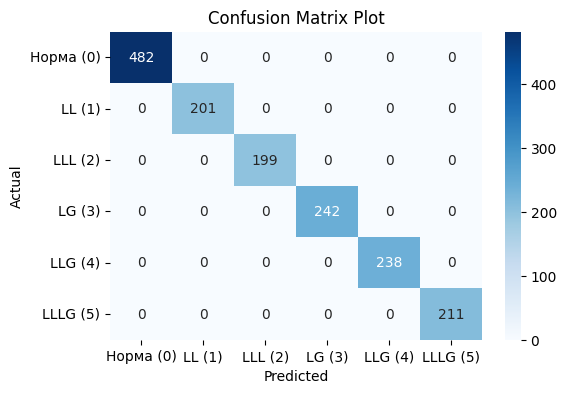

In [16]:
    model = Pipeline([
        ('u', RandomUnderSampler()),
        ("Naive bayes", GaussianNB()) ])

    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    # Вывод метрик
    labels = ['Норма (0)', 'LL (1)', 'LLL (2)', 'LG (3)', 'LLG (4)', 'LLLG (5)']
    print(classification_report(y_test, prediction, target_names=labels))

    conf_matrix = confusion_matrix(y_test, prediction)
    cm_df = pd.DataFrame(conf_matrix, index=['Норма (0)', 'LL (1)', 'LLL (2)', 'LG (3)', 'LLG (4)', 'LLLG (5)'], columns=['Норма (0)', 'LL (1)', 'LLL (2)', 'LG (3)', 'LLG (4)', 'LLLG (5)'])

    # Настройка отображения без научной нотации
    pd.options.display.float_format = '{:.0f}'.format

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix Plot")
    plt.show()